# Volume 3: Metropolis
    Samuel Goldrup
    MATH 405
    24 January 2023

In [1]:
import numpy as np
from scipy import stats
import matplotlib
matplotlib.use('nbAgg')
from matplotlib import pyplot as plt
from math import sqrt, exp, log
import seaborn as sbn

## Problem 1

Write a function that uses the Metropolis hastings algorithm to draw from the posterior distribution over the mean $\mu$ and variance $\sigma ^2$. Use the given functions and algorithm 1.1 to complete the problem.

Your function should return an array of draws, an array of the log probabilities, and an acceptance rate. 
Using the seaborn.kdeplot function, plot the first 500 log probabilitis, the $\mu$ samples and posterior distribution, and the $\sigma ^2$ samples and posterior distribution. 

(Hint: When checking your acceptance, remember you are in log space.)

Compare your results with Fig 1.1 and 1.2

In [2]:
def proposal(x,s):
    """The proposal function Q(x,y) = N(x|y,sI)."""
    return stats.multivariate_normal.rvs(mean=x, cov=s*np.eye(len(x)))

In [3]:
def propLogDensity(x):
    """Calculate the log of the proportional density."""
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=np.sqrt(x[1])).sum()
    return logprob    # ^this is where the scores are used.

In [4]:
def acceptance(x, y):
    return min(0, propLogDensity(x) - propLogDensity(y))

In [5]:
def metropolis(y0, s, n_samples):
    """Use the Metropolis algorithm to sample from posterior.
    Parameters:
     x0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
     s (float): The standard deviation parameter for the proposal function.
     n_samples (int): The number of samples to generate.
   
   Returns:
     draws ((n_samples, 2) ndarray): The MCMC samples.
     logprobs ((n_samples,) ndarray): The log density of the samples.
     accept_rate (float): The proportion of accepted proposed samples."""
    ys = [y0] #sequence of y's
    y = y0 #assign current y to be y0
    accepts = 0
    logprobs = []
    for i in range(n_samples):
        x = proposal(y,s) #sample x from proposal
        a = np.random.uniform(low=0.0,high=1.0) #a unif
        log_p = acceptance(x,y)
        if np.log(a) <= log_p: 
            accepts += 1
            y = x #accept this new draw for y
            ys.append(y)
        else:
            ys.append(y) #don't accept that new draw, go with what we got
    
        logprobs.append(propLogDensity(ys[-1]))
    acc_rate = accepts / n_samples
    return np.array(ys), logprobs, acc_rate

In [6]:
scores = np.load("examscores.npy")

alpha, beta = 3,50
m, s = 80, 4

muprior = stats.norm(loc=m, scale=np.sqrt(s**2))
sig2prior = stats.invgamma(alpha, scale=beta)

y0= np.array([40.3,10.])

outy,logps,acc_r = metropolis(y0,1,10000)

mus = outy[:,0]
var = outy[:,1]

<IPython.core.display.Javascript object>


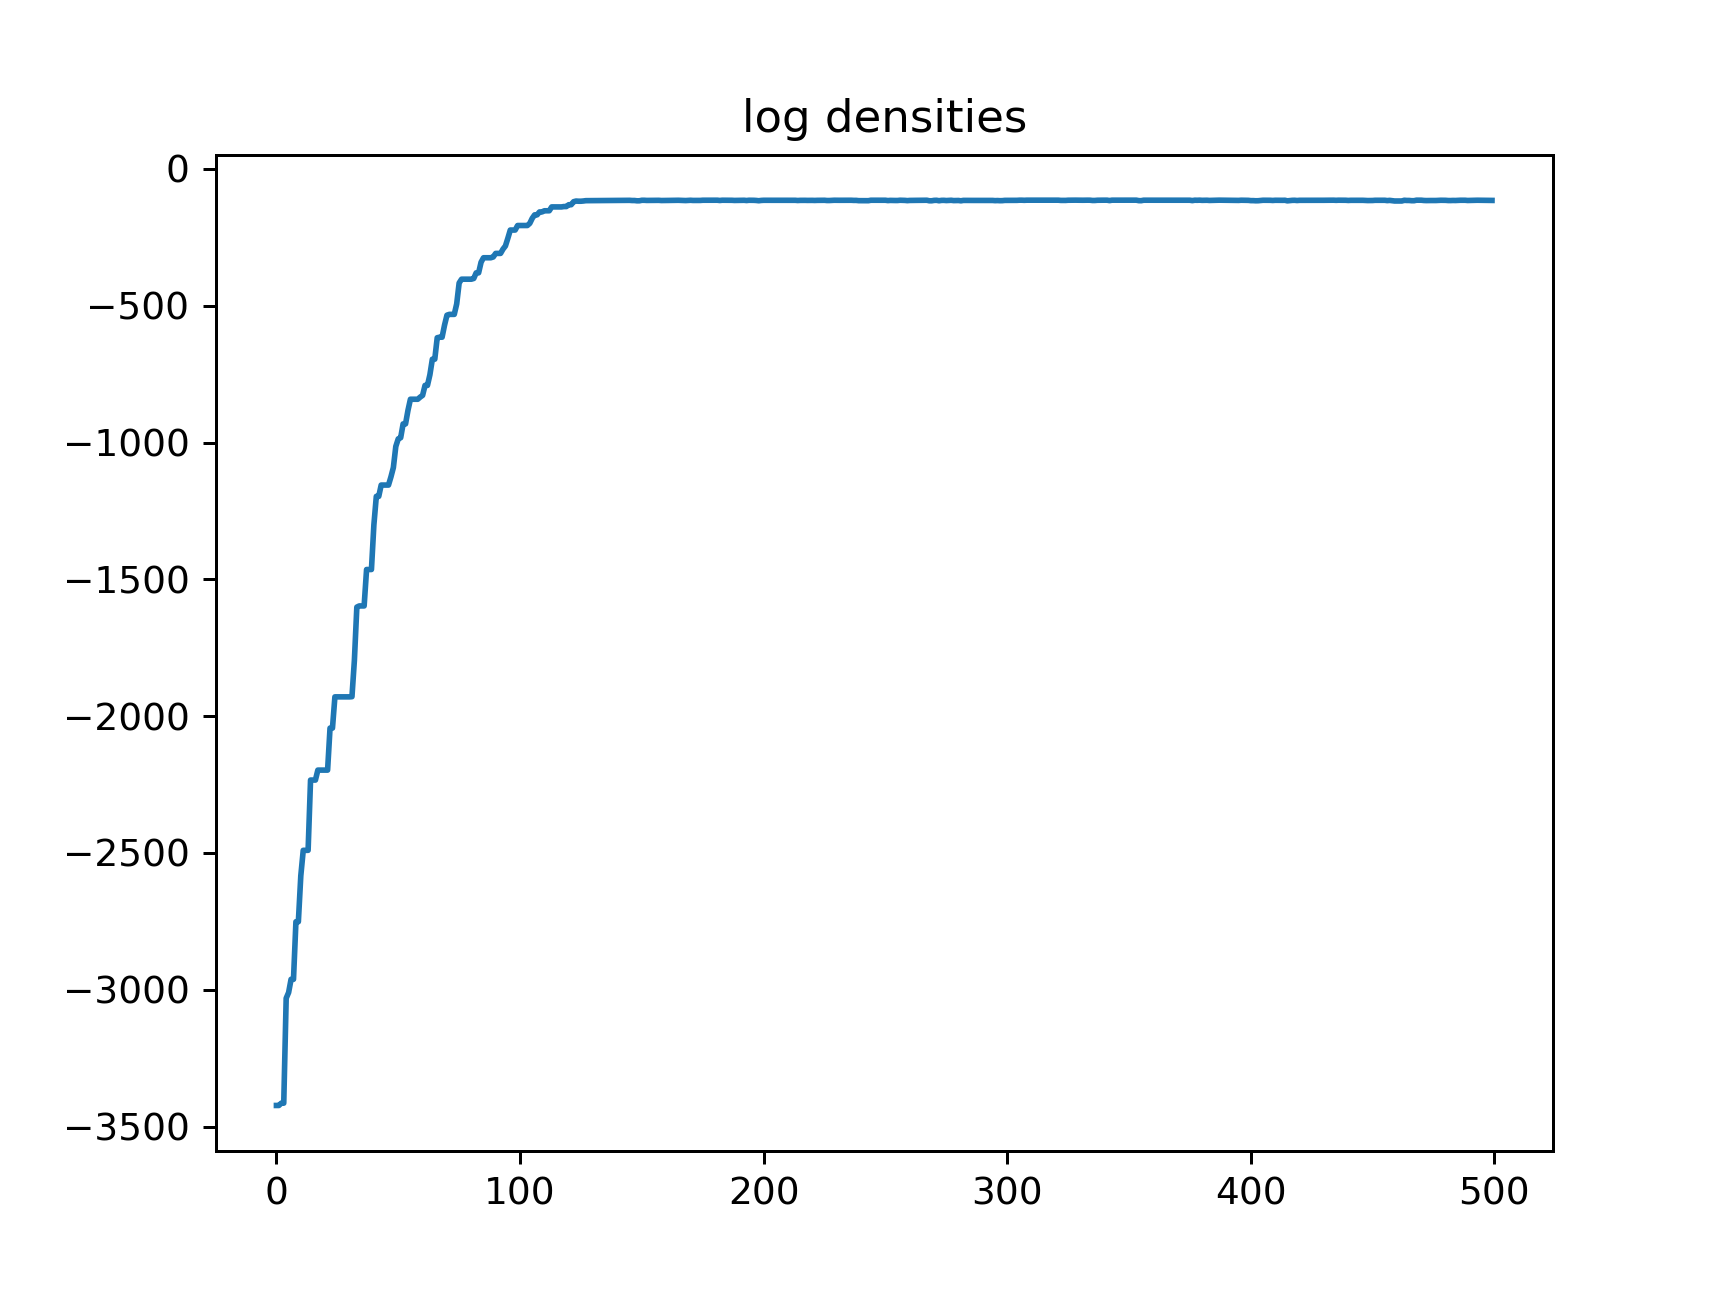

<IPython.core.display.Javascript object>


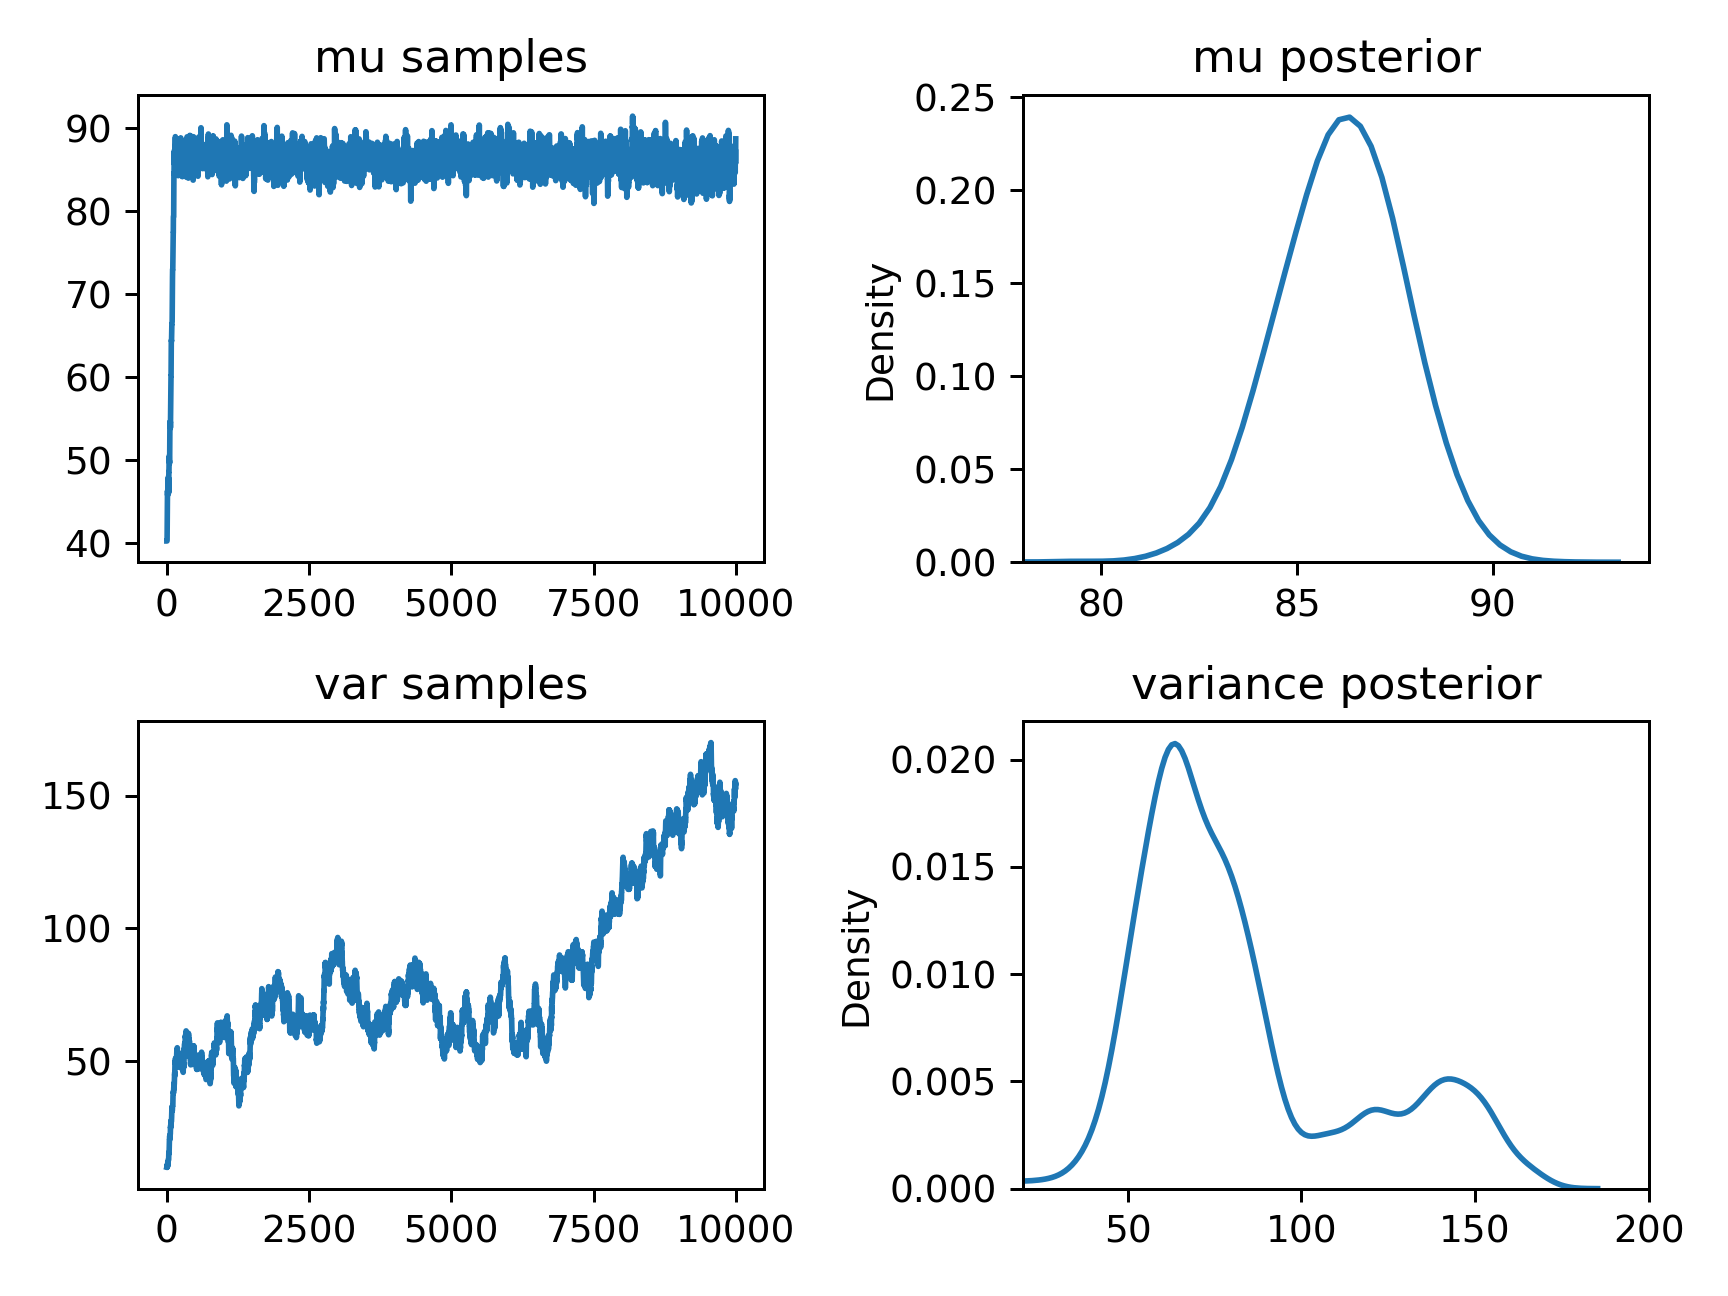

In [7]:
plt.plot(np.arange(500),logps[:500]) #first the probs
plt.title("log densities")
plt.show()

#then mu,var
plt.subplots(2,2)

plt.subplot(2,2,1).plot(mus)
plt.title("mu samples")

plt.subplot(2,2,2)
plt.title("mu posterior")
plt.xlim([78,94])
sbn.kdeplot(mus)


plt.subplot(2,2,3).plot(var)
plt.title("var samples")

plt.subplot(2,2,4)
plt.title("variance posterior")
plt.xlim([20,200])
sbn.kdeplot(var)

plt.tight_layout()
plt.show()

## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [8]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n,n))
    for k in range(n): #assigns entries randomly
        random_spin[k,:] = 2*np.random.binomial(1,.5, n) -1
    return random_spin

In [9]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    Parameter:
     L (ndarray): A lattice that we want the spin configuration for.
    
    Returns:
     (float): The spinfiguration of the lattice.
    """
    m,n = L.shape #roll slides the vector about an entry
    H = -np.sum([[np.product(np.roll(row,k)[:2]) for k in range(n)] for row in L]) - np.sum([[np.product(np.roll(row,k)[:2]) for k in range(n)] for row in L.T])
    return H

In [10]:
np.random.seed(12)
lattice_energy(random_lattice(100))

48.0

## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [11]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1.
    Parameter:
     n (int): 1/(n^2) probability for each location
     
    Returns:
     (index1, index2) (tuple): the tuple pair of the chosen indices. 
    """
    #pick a place to flip
    return tuple(np.random.randint(low=0,high=n,size=2))
#     return np.random.randint(0,n), np.random.randint(0,n)

## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [12]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    
    Parameters:
     L (ndarray): the spin configuration 
     L_energy (float): the energy of the spin configuration.
     i (int): the first index.
     j (int): the second index.
    Returns:
     (float): the energy of the new updated lattice
    """
    n = L.shape[0] #square matrix
    hor_n = np.array([i-1,i+1]) #horizontal and vertical neighbors
    vert_n = np.array([j-1,j+1]) 
    pairs = [L[i-1%n,j],L[(i+1)%n,j],L[i,(j-1)%n],L[i,(j+1)%n]]
    L_energy += 2 * np.sum(pairs)*L[i,j] #do the flip
    return L_energy

In [13]:
np.random.seed(12)
L = random_lattice(100)
L_e = lattice_energy(L)
i,j = flip_location(100)
print(i,j)
updated_energy(L,L_e,77,94)

77 94


52.0

## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

(Hint: np.random.binomial() might be useful function)

In [14]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration.
    
    Parameters:
     beta (float): a quantity inversly proportional to the temperature.
     energy_old (float): the energy of the old lattice.
     energy_new (float): the energy of the updated lattice.
     
    Returns:
     (boolean): whether the new energy should be accepted or not
    """
    if energy_new < energy_old: #always accept energy improvement
        return True
    else:
        p = np.exp(beta*(energy_old-energy_new))
        return np.random.binomial(1,p)

## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


In [15]:
def ising_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    energies = [] #to track these values
    lattices = []
    acc_cnt = 0
    
    lattice = random_lattice(n) 
    energy_old = lattice_energy(lattice) 
    
    for i in range(burn_in):
    
        i,j = flip_location(n) #do the flip, get the energy
        energy_new = updated_energy(lattice,energy_old,i,j)
        
        #evaluate the flip
        if accept(beta,energy_old,energy_new):
            lattice[i,j] *= -1
            energy_old = energy_new 
            energies.append(-beta*energy_old)
        else:
            energies.append(-beta*energy_old)
    
    for i in range(n_samples):
        i,j = flip_location(n) #do the flip, get the energy
        energy_new = updated_energy(lattice,energy_old,i,j)
        
        #evaluate the flip
        if accept(beta,energy_old,energy_new):
            acc_cnt += 1
            lattice[i,j] *= -1
            energy_old = energy_new
        else:
            pass
            
        if i % 100: #now that we burned in, track lattices, energies
            pass
        else:
            energies.append(-beta*energy_old)
            lattices.append(lattice)
            
    acc_rate = acc_cnt / n_samples
            
    return lattices,energies,acc_rate

<IPython.core.display.Javascript object>


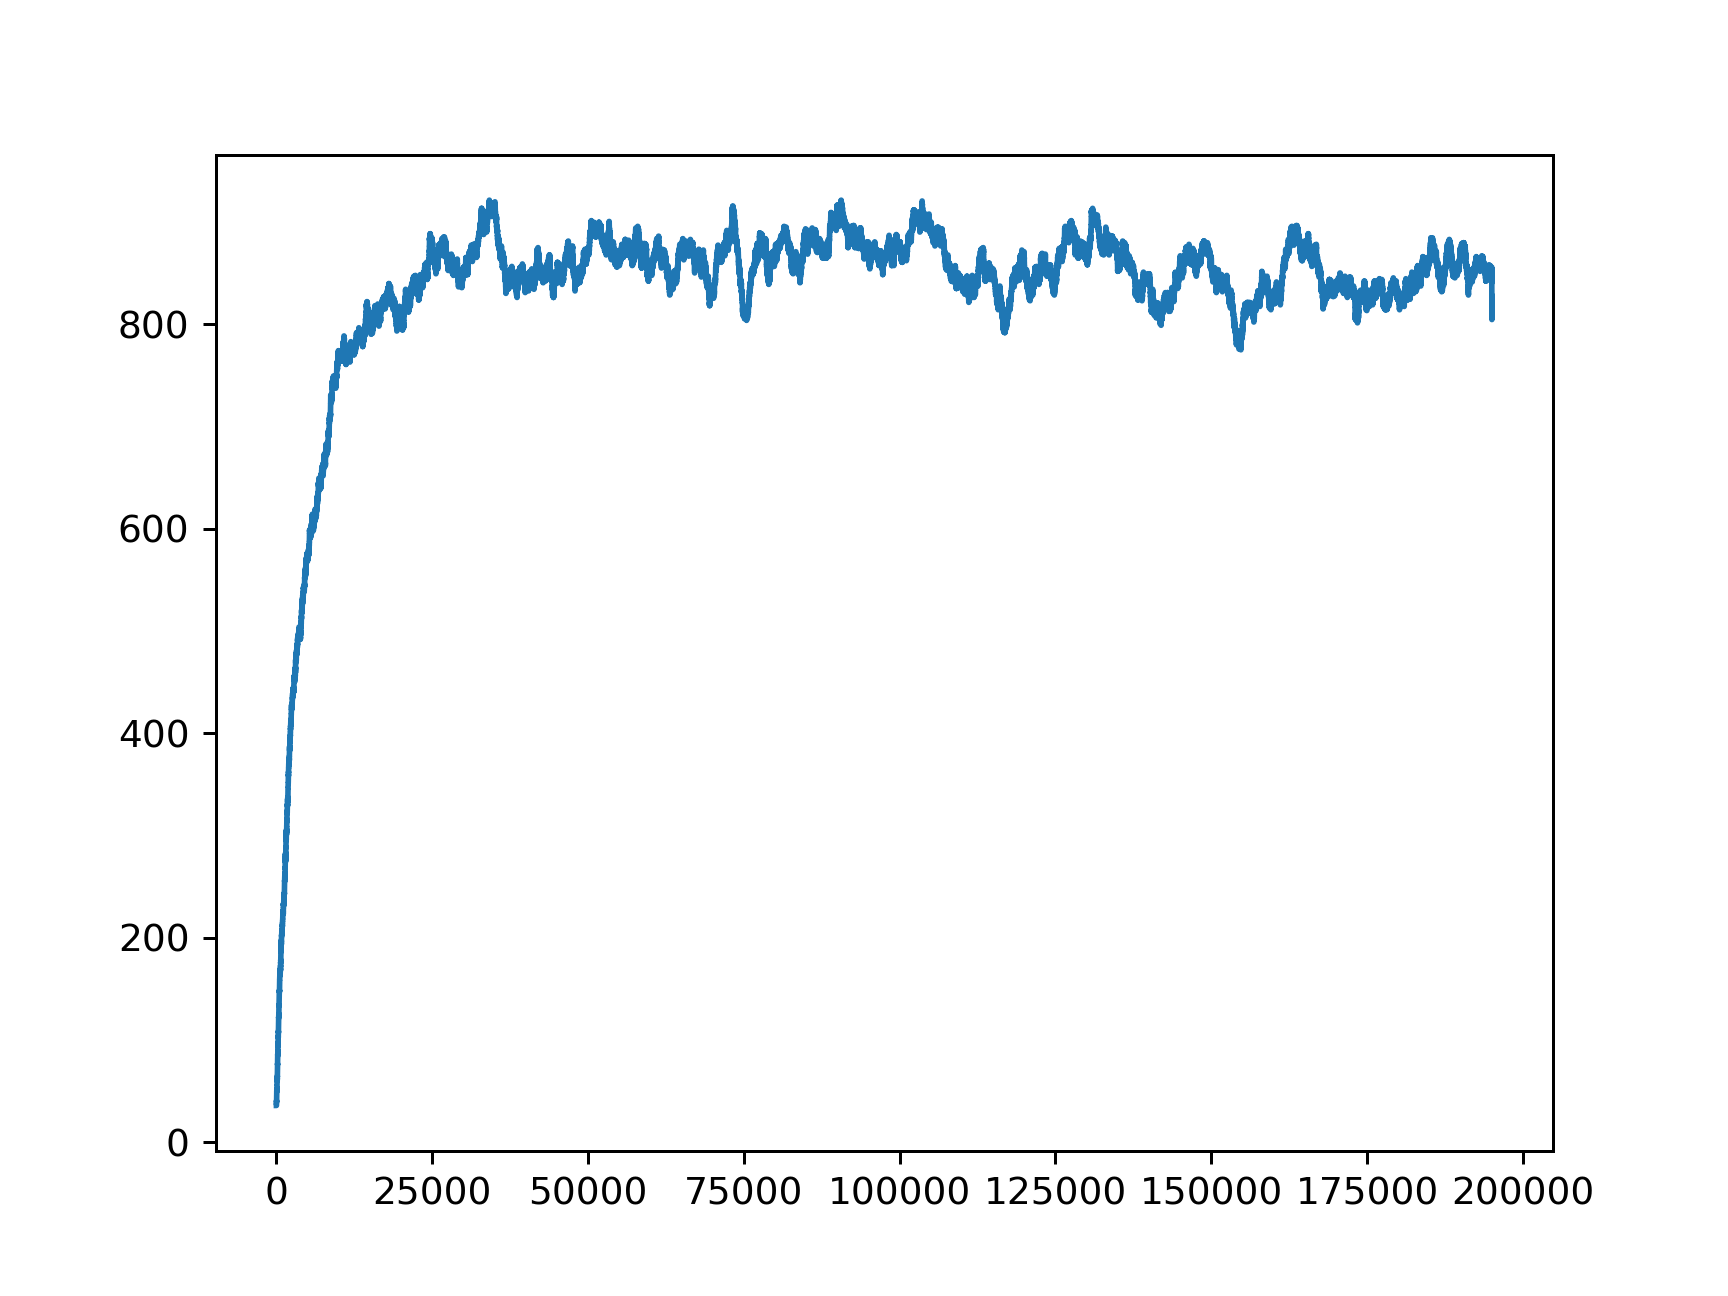

<IPython.core.display.Javascript object>


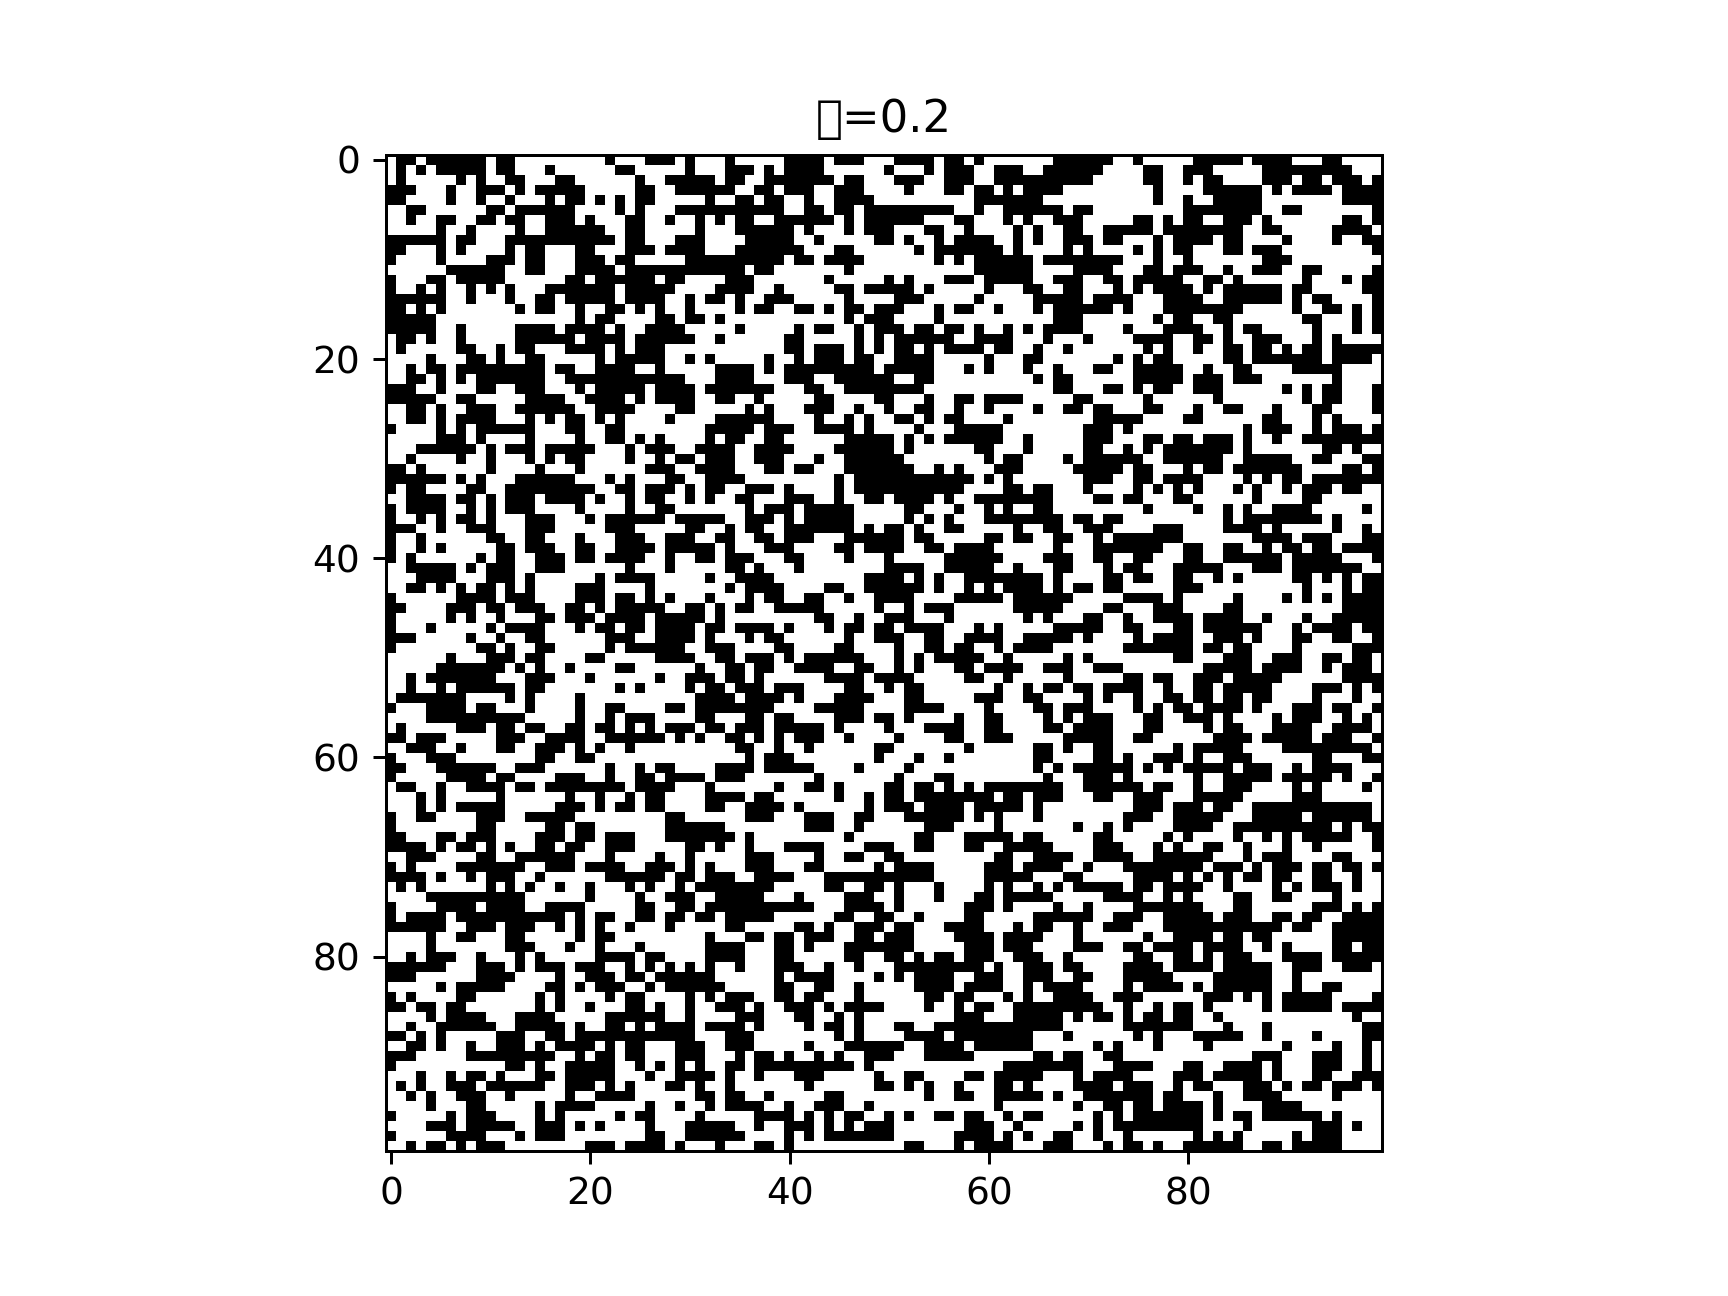

In [17]:
𝛽s = [0.2,0.4,1]

lattices,energies,acc_rate = ising_metropolis(beta=𝛽s[0])
plt.plot(energies)
plt.show()
L = lattices[-1]
plt.title(f"𝛽={𝛽s[0]}")
plt.imshow(L,cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


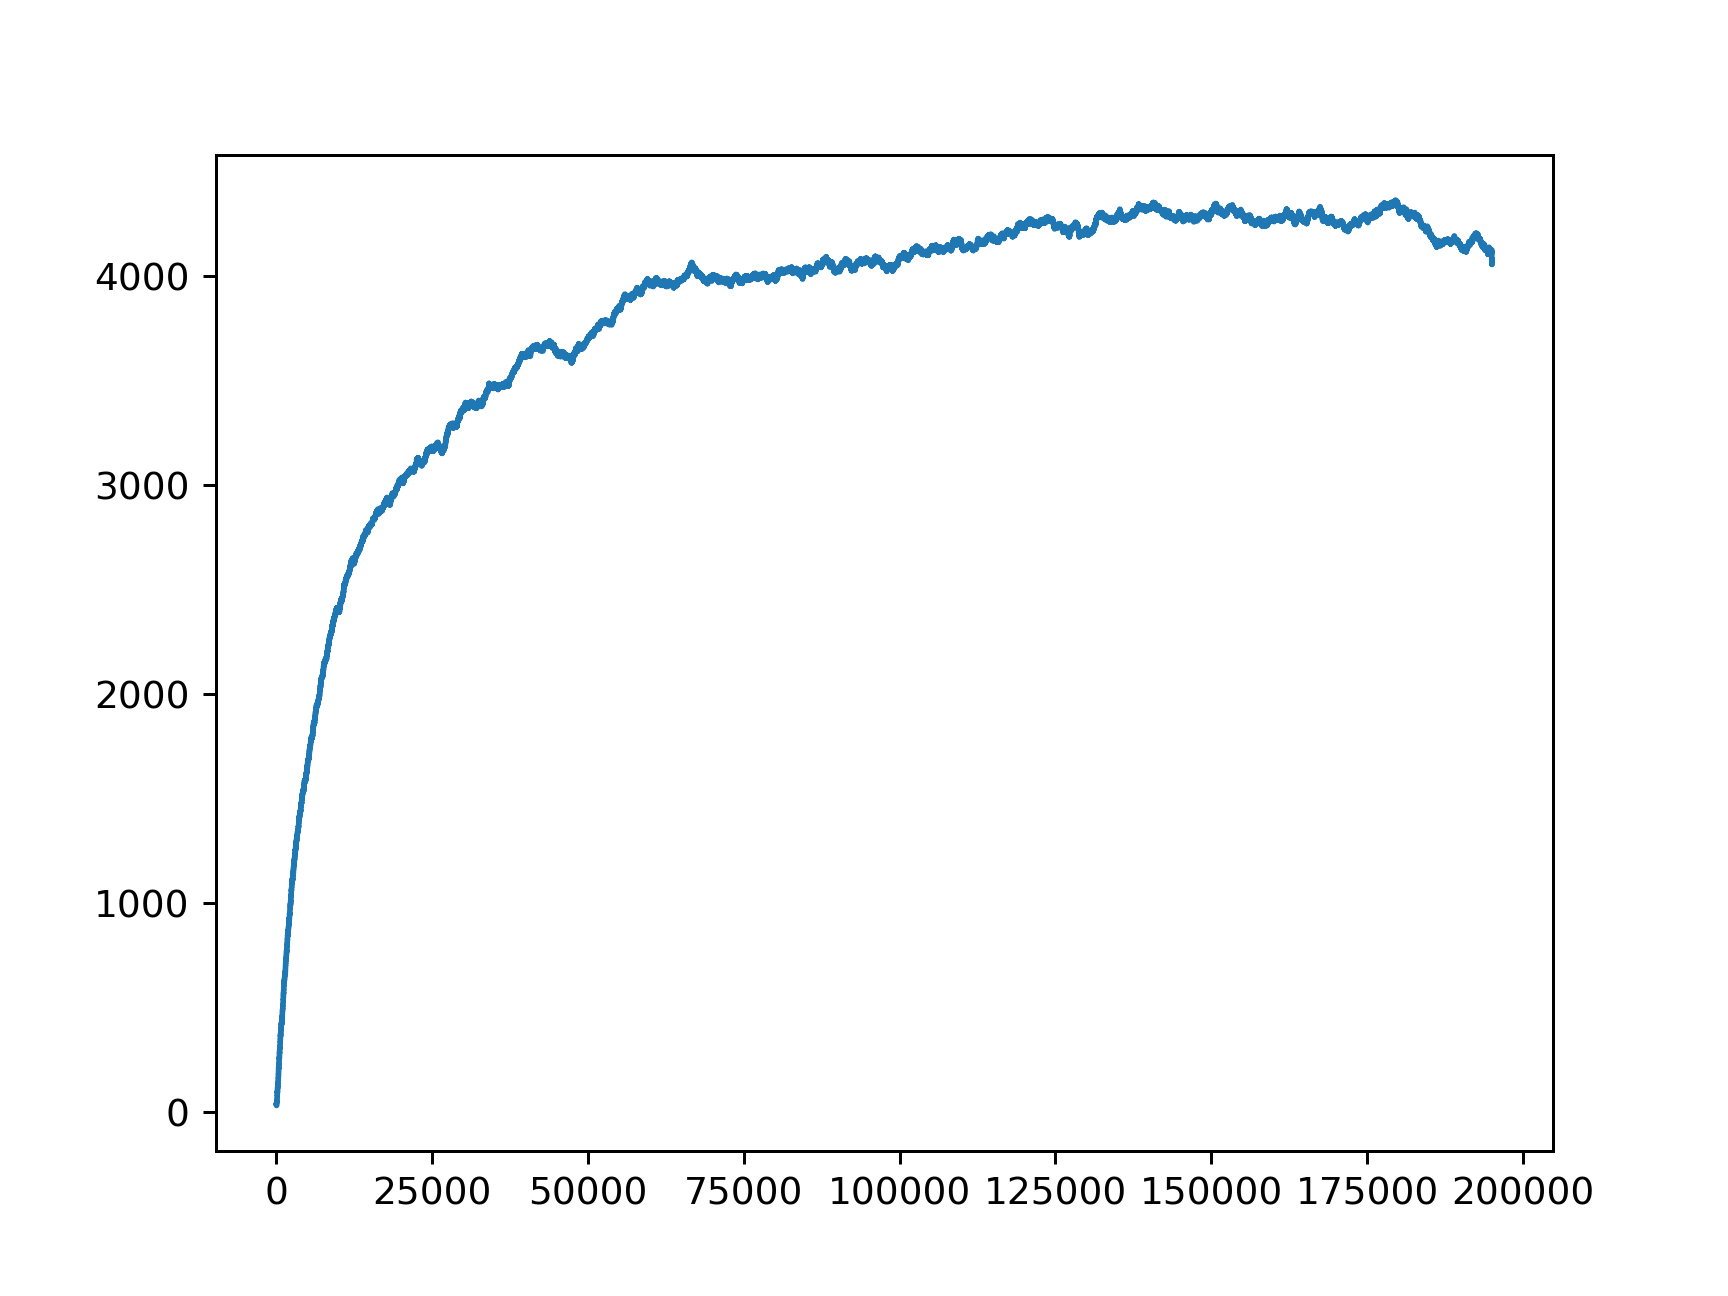

<IPython.core.display.Javascript object>


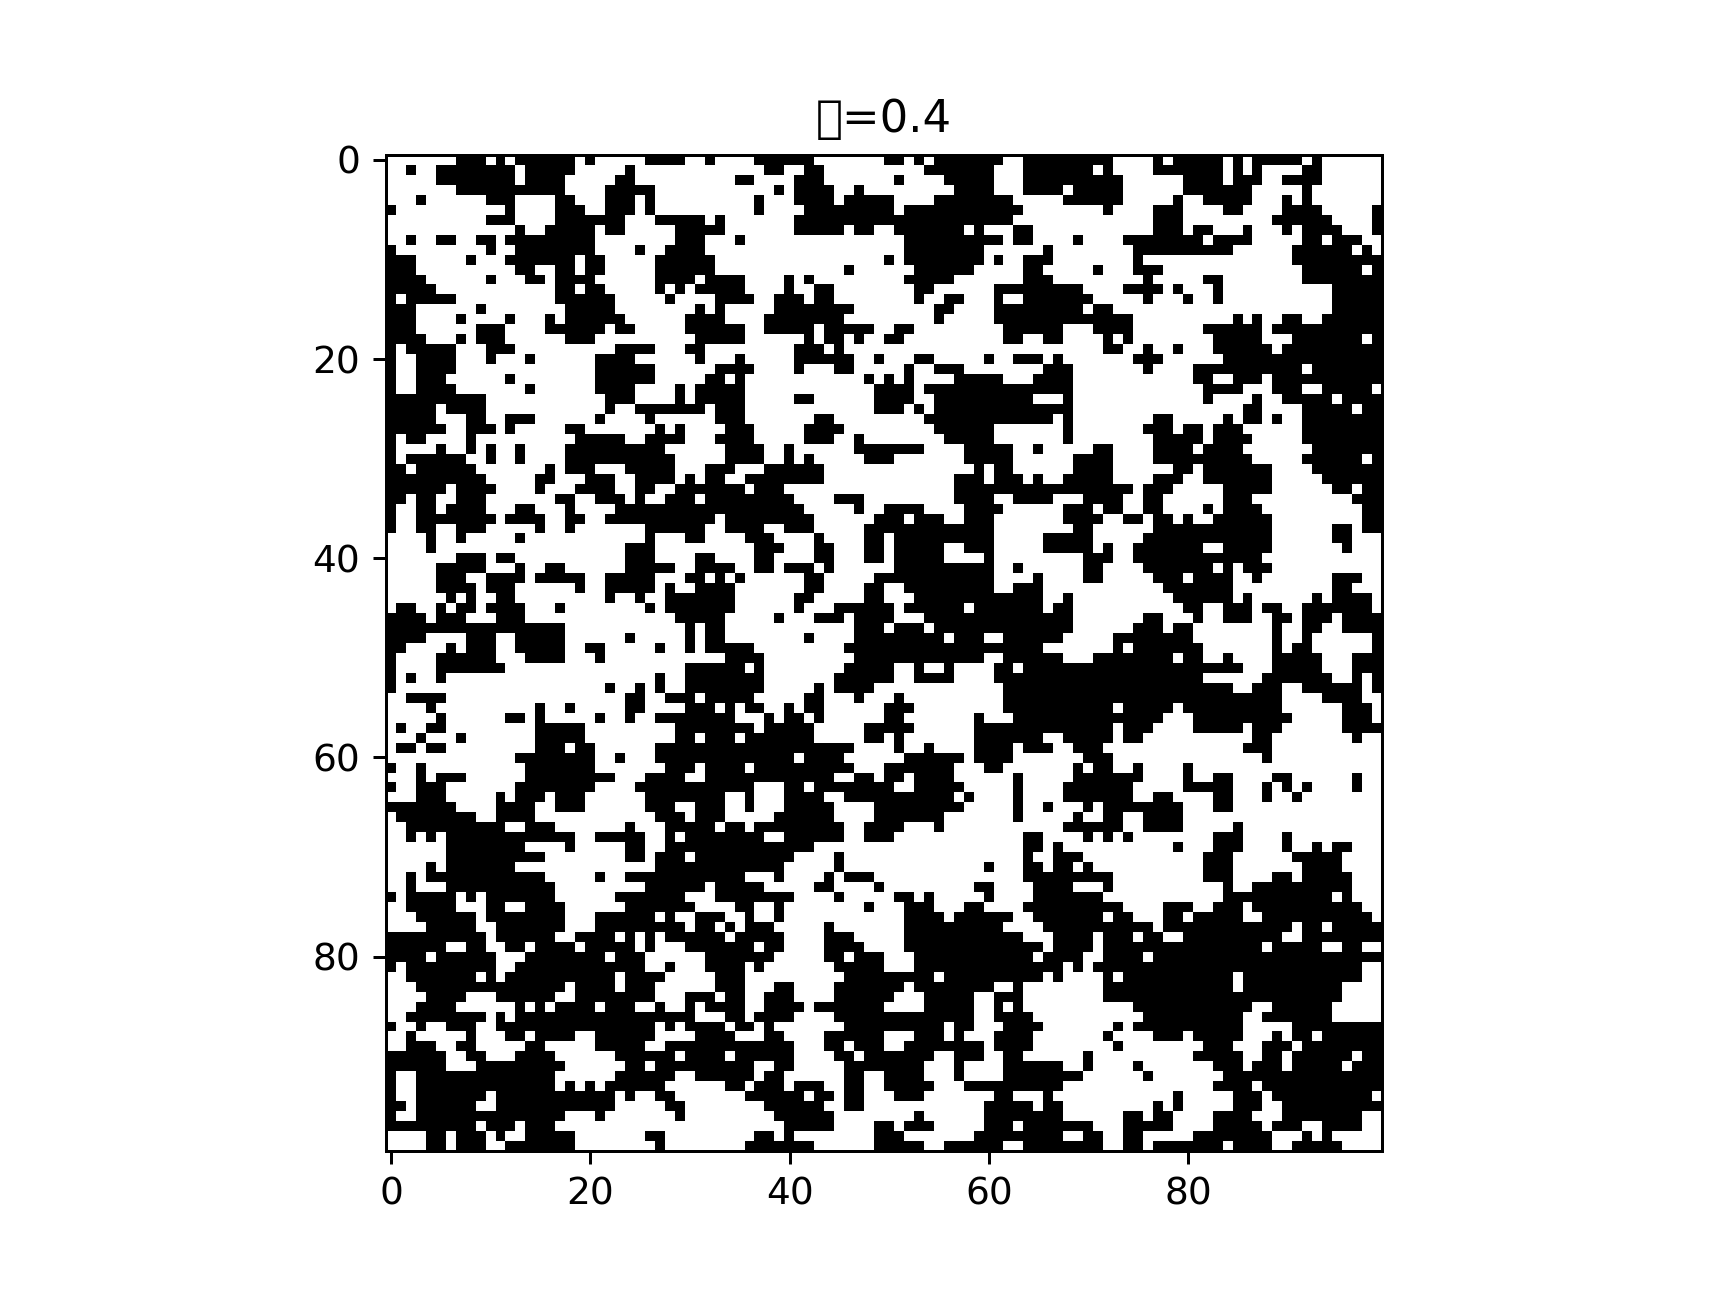

In [18]:
lattices,energies,acc_rate = ising_metropolis(beta=𝛽s[1])
plt.plot(energies)
plt.show()
L = lattices[-1]
plt.title(f"𝛽={𝛽s[1]}")
plt.imshow(L,cmap='gray')
plt.show()

<IPython.core.display.Javascript object>


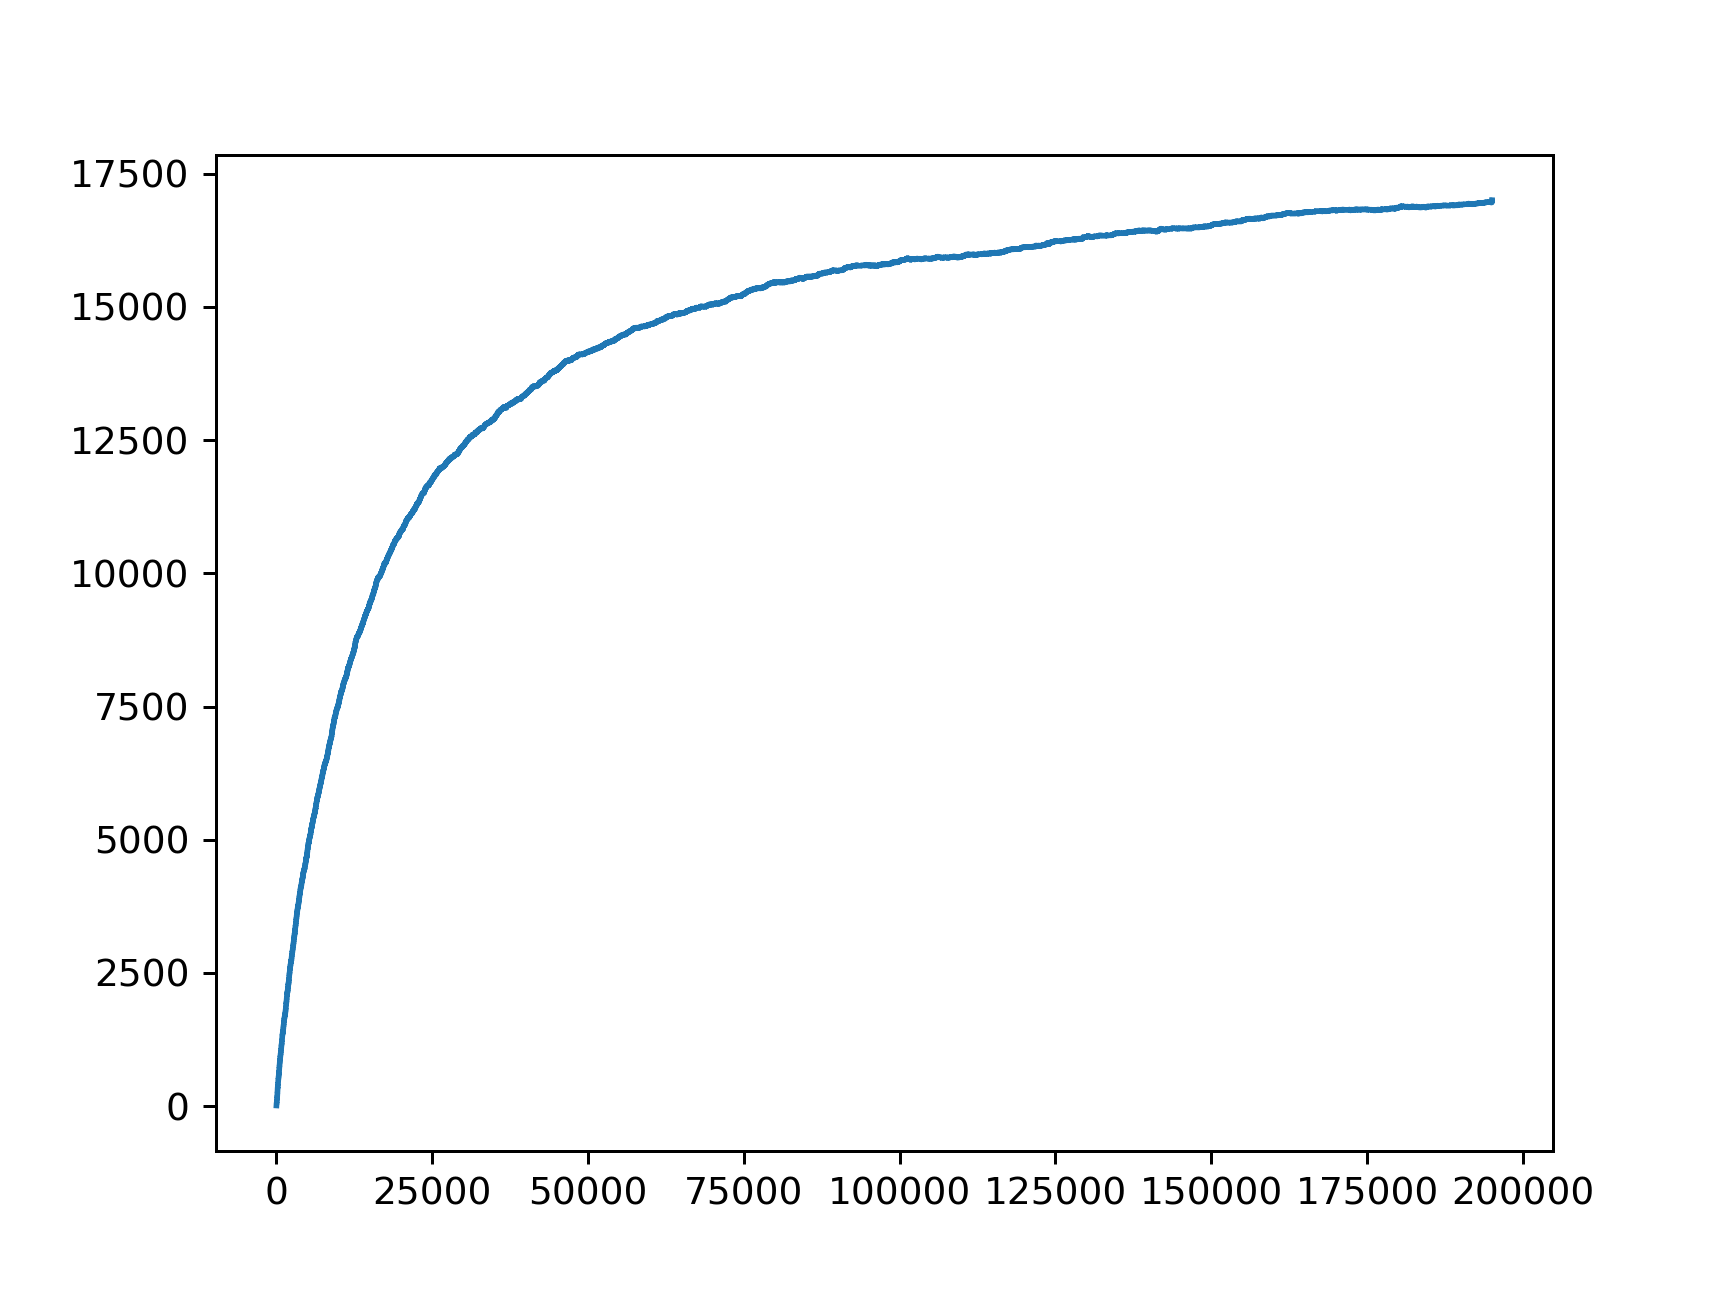

<IPython.core.display.Javascript object>


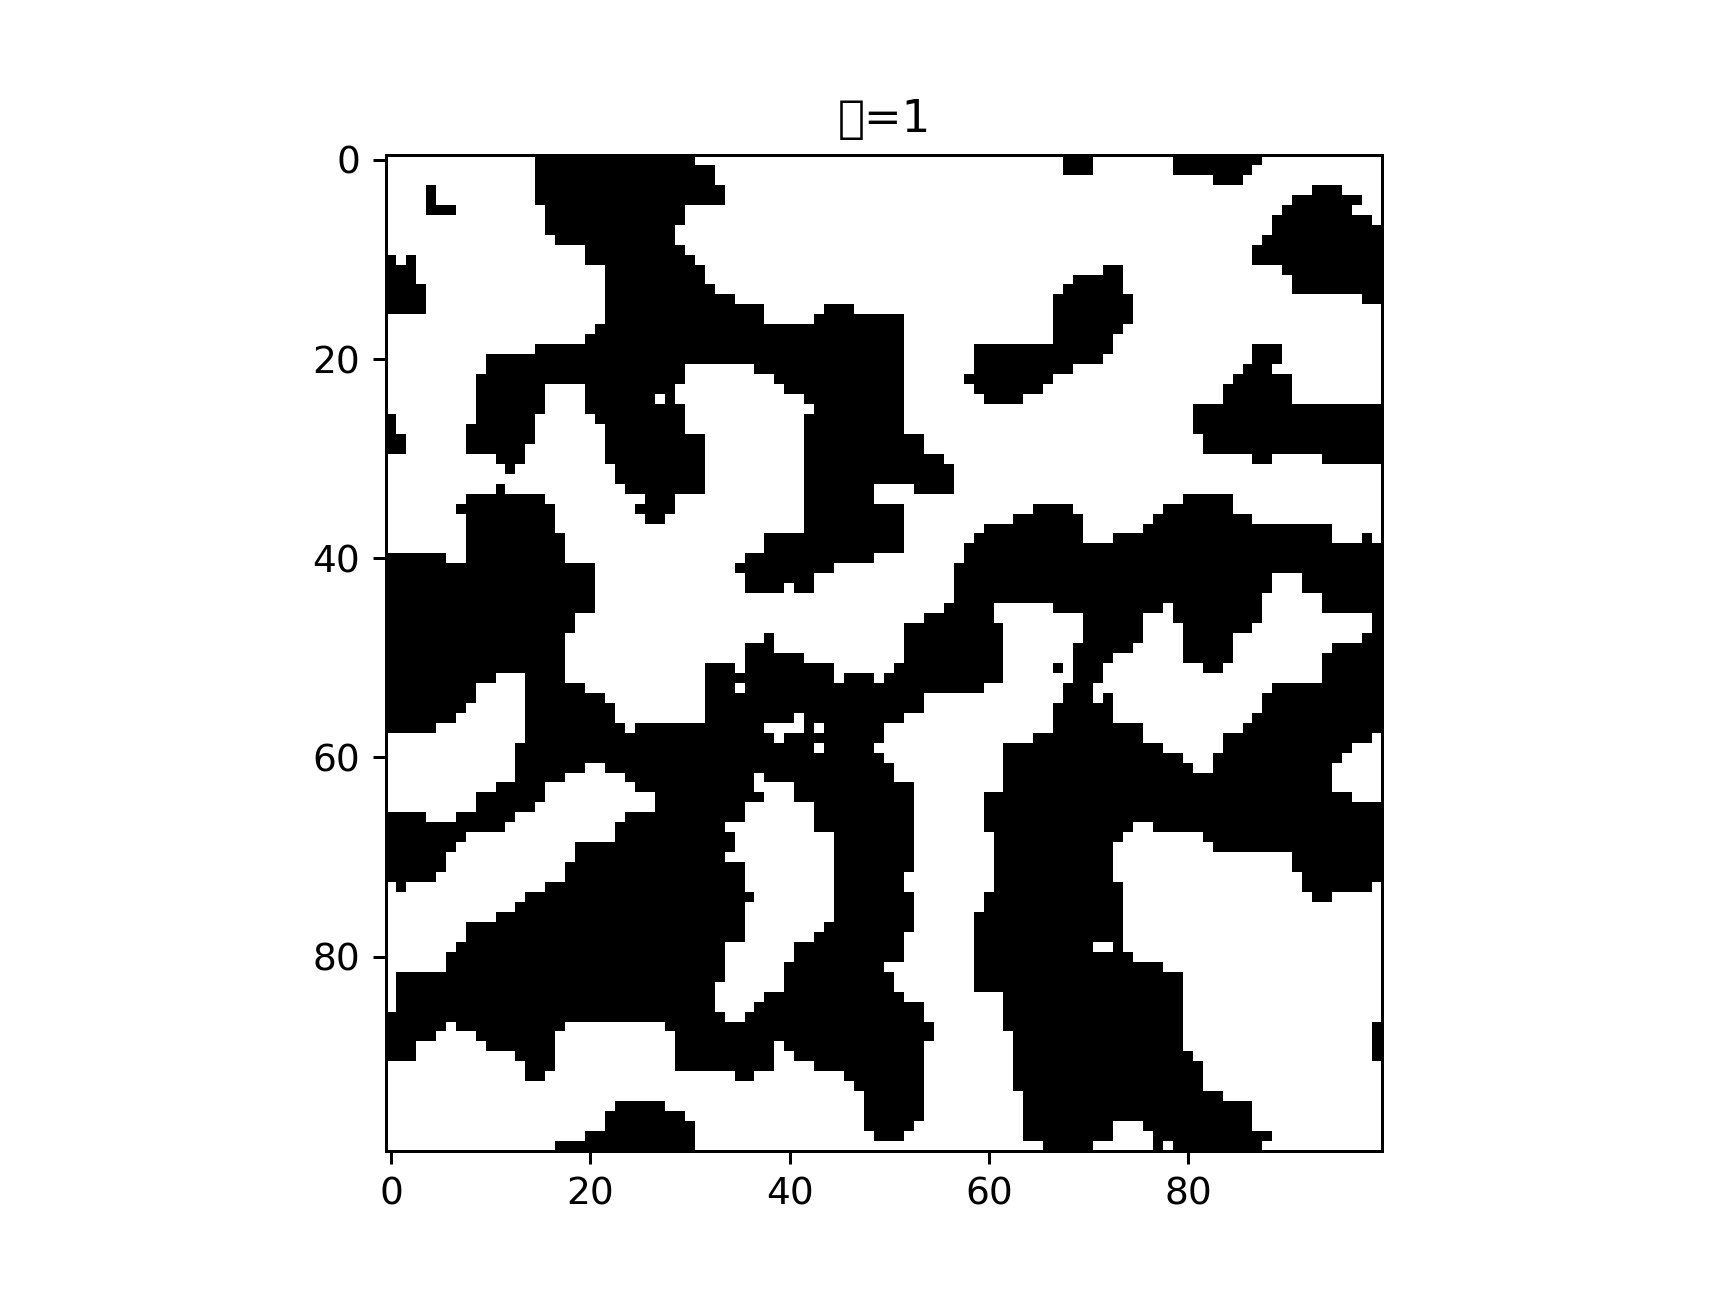

In [19]:
lattices,energies,acc_rate = ising_metropolis(beta=𝛽s[2])
plt.plot(energies)
plt.show()
L = lattices[-1]
plt.title(f"𝛽={𝛽s[2]}")
plt.imshow(L,cmap='gray')
plt.show()